### Download data from GCS


In [205]:
# from google.colab import auth
# auth.authenticate_user()

In [ ]:
# !curl https://sdk.cloud.google.com | bash
# !gcloud init

In [ ]:
# !mkdir ./data
# !gsutil -m cp -r "gs://futoshiki-solver/box_segmentation"

![](./unet_arch.png)

From paper: 

### 2 Network Architecture
The network architecture is illustrated in Figure 1. It consists of a contracting
path (left side) and an expansive path (right side). The contracting path follows
the typical architecture of a convolutional network. It consists of the repeated
application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
for downsampling. At each downsampling step we double the number of feature
channels. Every step in the expansive path consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in
every convolution. At the final layer a 1x1 convolution is used to map each 64-
component feature vector to the desired number of classes. In total the network
has 23 convolutional layers.
To allow a seamless tiling of the output segmentation map (see Figure 2), it
is important to select the input tile size such that all 2x2 max-pooling operations
are applied to a layer with an even x- and y-size.

* Unet works with single channel images
* Each block on the downscale path doubles the number of channels
* Skip connections between downscale and upscale paths require the cropping of
  image maps, to compensate for the pixels lost at the edges due to conv /
  upconv operations

An expansion on this is the Unet++ architecture, which utilises additional
convolutional layers to combine the encoder and decoder pathways instead of
purely skip connections. Additional loss terms were also added to the
intermediate feature maps which have the same resolution as the input images.

Interestingly, this network can also be pruned after training to a smaller
subset, without degrading performance too much

![](./unet%2B%2B.png)

Lets try and implement 

In [3]:
import torch
from torchvision.transforms.functional import center_crop

In [198]:
class ConvBlock(torch.nn.Module):
    """
    A convolutional block used in the Unet model for both encoder and decoder pathways
    
    In the encoder path, generally the first convolution doubles the number of
    channels. Conversely the number of channels is halved by the first
    convolution in the decoder path.
    
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.first_conv = torch.nn.Conv2d(in_channels, out_channels, (3,3))
        self.second_conv = torch.nn.Conv2d(out_channels, out_channels, (3,3))
        
    def forward(self, x):
        x = self.first_conv(x)
        x = torch.relu(x)
        x = self.second_conv(x)
        x = torch.relu(x)
        return x
        

class Unet(torch.nn.Module):
    def trainable_parameters(self):
        """Get the number of trainable parameters, without double counting
        shared weights"""
        return sum({p.data_ptr(): p.numel() for p in self.parameters() if p.requires_grad}.values())
    
    def __init__(self):
        super().__init__()
        # using nn.ModuleList ensures that parameters are registered with torch
        self.encoder_blocks = torch.nn.ModuleList([
            ConvBlock(3, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
            ConvBlock(512, 1024),
        ])
        self.decoder_blocks = torch.nn.ModuleList([
            ConvBlock(1024, 512),
            ConvBlock(512, 256),
            ConvBlock(256, 128),
            ConvBlock(128, 64),
        ])
        self.up_convs = torch.nn.ModuleList([
            torch.nn.ConvTranspose2d(1024, 512, (2,2), stride=2),
            torch.nn.ConvTranspose2d(512, 256, (2,2), stride=2),
            torch.nn.ConvTranspose2d(256, 128, (2,2), stride=2),
            torch.nn.ConvTranspose2d(128, 64, (2,2), stride=2),
        ])
        self.max_pool = torch.nn.MaxPool2d((2,2), stride=2)
        self.projection_conv = torch.nn.Conv2d(64, 1, (1,1))
        
    def forward(self, x, debug=False):
        skip_cons = []
        for b in self.encoder_blocks[:-1]:
            x = b(x)

            skip_cons.append(x.clone())
            x = self.max_pool(x)

            
        # we don't need a skip connection or max pool for the last block
        x = self.encoder_blocks[-1](x)
            
        for b, up in zip(self.decoder_blocks, self.up_convs):
            x = up(x)
            
            skip = skip_cons.pop()
            # crop to HW of decoder resolution (should be square but we
            # explicitly set both dimensions)
            skip = center_crop(skip, (x.shape[2], x.shape[3]))
            # concatenate channel-wise
            x = torch.cat((skip, x), dim=1)

            x = b(x)

        return self.projection_conv(x)
            
        

### TODOs

* Add loss
* Add data + dataloader
* Try training model!

extensions!

* rewrite conv2d from torch basics - how do we translate the conv kernel so that the
forward conv operation is a matrix multiplication?


### Next

* Attention + transformers
  * could try Andrej's NanoGPT lecture?
  * jay alamaar
  * ViT

In [170]:
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from PIL import Image
import functools
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.ops import sigmoid_focal_loss

In [154]:
data_path = '../data/box_segmentation'

x_all_train_path = os.path.join(data_path, 'all_train')
x_train_path = os.path.join(data_path, 'train')
x_valid_path = os.path.join(data_path, 'validation')
x_test_path = os.path.join(data_path, 'test')

y_train_path = os.path.join(data_path, 'labels', 'train.csv')
y_valid_path = os.path.join(data_path, 'labels', 'valid.csv')
y_test_path = os.path.join(data_path, 'labels', 'test.csv')

In [155]:
def image_transpose_exif(im: np.array) -> np.array:
    """Transpose smartphone images that mave be incorrectly oriented.

    Apply Image.transpose to ensure 0th row of pixels is at the visual
    top of the image, and 0th column is the visual left-hand side.
    Return the original image if unable to determine the orientation.

    As per CIPA DC-008-2012, the orientation field contains an integer,
    1 through 8. Other values are reserved.

    Parameters
    ----------
    im: PIL.Image
       The image to be rotated.
    """

    exif_orientation_tag = 0x0112
    exif_transpose_sequences = [                   # Val  0th row  0th col
        [],                                        #  0    (reserved)
        [],                                        #  1   top      left
        [Image.FLIP_LEFT_RIGHT],                   #  2   top      right
        [Image.ROTATE_180],                        #  3   bottom   right
        [Image.FLIP_TOP_BOTTOM],                   #  4   bottom   left
        [Image.FLIP_LEFT_RIGHT, Image.ROTATE_90],  #  5   left     top
        [Image.ROTATE_270],                        #  6   right    top
        [Image.FLIP_TOP_BOTTOM, Image.ROTATE_90],  #  7   right    bottom
        [Image.ROTATE_90],                         #  8   left     bottom
    ]

    try:
        seq = exif_transpose_sequences[im._getexif()[exif_orientation_tag]]
    except Exception:
        return im
    else:
        return functools.reduce(type(im).transpose, seq, im)

In [172]:
class FutoshikiGridDataset(Dataset):
    """Futoshiki Grid dataset."""

    def __init__(self, csv_file, root_dir, resize=None, transform=None, augmentation=None, copies=None, torch=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.grid_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.resize = resize
        self.transform = transform
        self.augmentation = augmentation
        self.copies = copies
        self.torch = torch

    def __len__(self):
        if self.copies:
            return self.grid_frame.shape[0] * self.copies
        else:
            return self.grid_frame.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if self.copies:
            idx = idx % self.grid_frame.shape[0]

        img_name = os.path.join(self.root_dir,
                                self.grid_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        image = image_transpose_exif(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        shape = image.shape
                
        grid = self.grid_frame.loc[idx, 'region_shape_attributes']
        mask = get_mask(grid, shape[:2])
        mask = mask / 255 # normalise
        
        if self.resize is not None:
            image, mask = cv2.resize(image, (572, 572)), cv2.resize(mask, (572, 572))
            mask = mask.reshape((*mask.shape, 1))
            
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if self.torch:
            # torch convention is BCHW, rather than current BHWC
            image = torch.tensor(image).permute(2, 0, 1) / 255
            mask = torch.tensor(mask).permute(2, 0, 1)
        
        return image, mask

def get_mask(row, shape):
    row = json.loads(row)
    coords = np.array([[x,y] for x, y in zip(row['all_points_x'], row['all_points_y'])])
    mask = np.zeros((*shape, 1))
    cv2.fillPoly(mask, [coords], 255)
    return mask

In [173]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(4, 3))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title(), color='white')
        plt.imshow(image)
    plt.show()

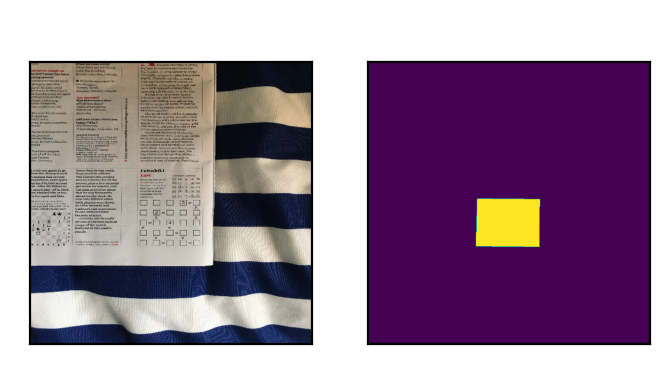

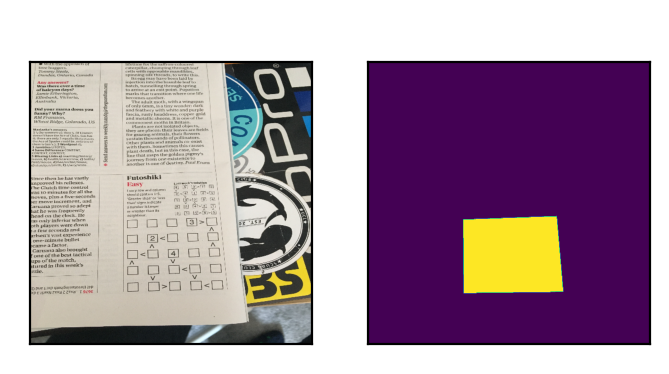

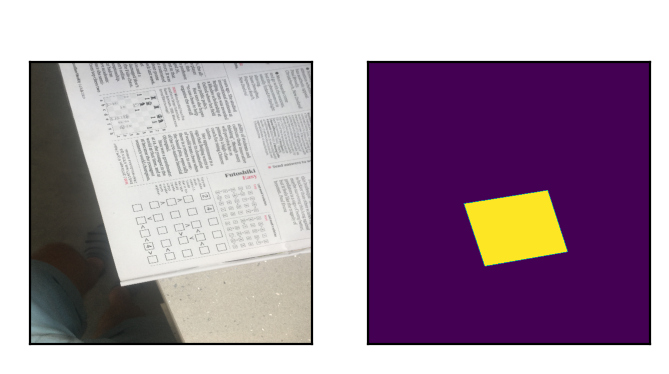

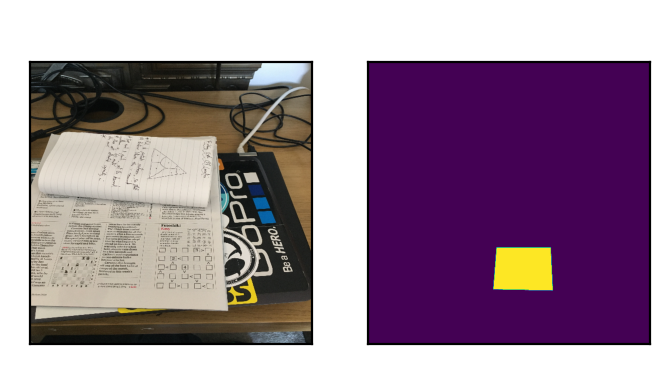

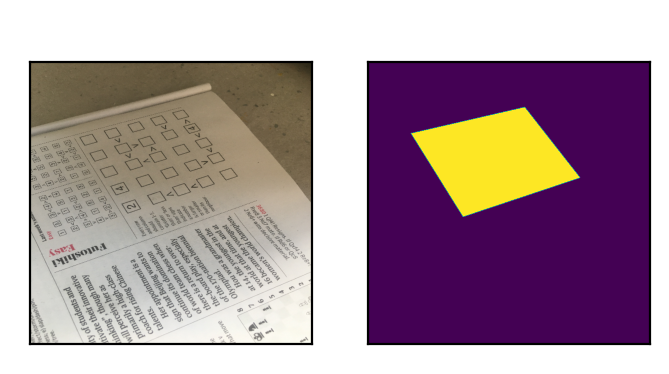

In [176]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

grid_dataset = FutoshikiGridDataset(y_train_path, x_train_path, True)

for x in range(5):
    out = grid_dataset[x]
    visualize(
        image = out[0],
        mask = out[1].squeeze()
    )

In [199]:
train_dataset = FutoshikiGridDataset(y_train_path, x_train_path, True, torch=True)
print('Number of training samples:', len(train_dataset))

val_dataset = FutoshikiGridDataset(y_valid_path, x_valid_path, True, torch=True)

Number of training samples: 43


In [200]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
# we only have 8 validation images
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

In [203]:
# training loop
n = 100
m = Unet()
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)

print(f"{m.trainable_parameters()=}")

for i in range(n):
    m.train()
    optimizer.zero_grad()
    
    train_features, train_labels = next(iter(train_loader))
    logits = m(train_features)
    
    train_loss = sigmoid_focal_loss(logits, center_crop(train_labels, logits.shape[2]), reduction="mean")
    
    train_loss.backward()
    optimizer.step()
        
    
    m.eval()
    
    val_features, val_labels = next(iter(val_loader))
    val_logits = m(val_features)
    
    val_loss = sigmoid_focal_loss(val_logits, center_crop(val_labels, val_logits.shape[2]), reduction="mean")
    
    print(f"{i=} {train_loss.item()=} {val_loss.item()=}")

m.trainable_parameters()=31031745
i=0 train_loss.item()=0.1178199074833493 val_loss.item()=0.10955382793083104
i=1 train_loss.item()=0.10404584395380154 val_loss.item()=0.09451158953370023
i=2 train_loss.item()=0.10162748066186568 val_loss.item()=0.0639240771884851
i=3 train_loss.item()=0.06440737588527742 val_loss.item()=0.9620074036451994
i=4 train_loss.item()=0.7257203929055714 val_loss.item()=0.05818092570152632
i=5 train_loss.item()=0.04302390315916709 val_loss.item()=0.06368456431179145
i=6 train_loss.item()=0.06673604162013581 val_loss.item()=0.06897446419087054
i=7 train_loss.item()=0.06477657363056778 val_loss.item()=0.07112630835552806
i=8 train_loss.item()=0.07328663299694003 val_loss.item()=0.07117430218184322
i=9 train_loss.item()=0.07164881766359571 val_loss.item()=0.06972322430075159
i=10 train_loss.item()=0.06811302328369968 val_loss.item()=0.06730641163784311
i=11 train_loss.item()=0.07156577338165954 val_loss.item()=0.06388537785095363
i=12 train_loss.item()=0.0690221

KeyboardInterrupt: 